# FASHION MNIST DATASET WITH NOVEL CLASS

L'idea del notebook è quello di investigare quali siano i vantaggi e le informazioni che le reti bayesiane, in un contesto di classificazione, possano apportare alla previsione.

Il dataset che si utilizzerà per l'analisi è il **Fashion MNIST**, dataset già presente nella libreria di keras, che consiste in circa 60'000 immagini 28x28 in scala di grigi che rappresentano 10 diverse categorie di abbigliamento. 
Durante l'analisi si implementano una tradizionale **rete neurale non Bayesiana** e **due reti neurali Bayesiane**, una attraverso l'uso dell'inferenza variazionale e una attraverso l'uso dell'MC Dropout. 

Al dataset originale verrà eliminata una delle categorie in modo tale da stimare i tre modelli probabilistici sulla base delle 9 classi. 
Successivamente verranno valutate le performance dei 3 modelli sulle 9 classi note e si investigheranno e confronteranno le incertezze espresse dalla rete neurale sia per le classi note sia per quelle non note. Per concludere si utilizzeranno queste forme di incertezza per trovare la nuova classe e filtrare le previsioni incerte.



In [ ]:
import tensorflow as tf

In [ ]:
# !pip install tensorflow_probability==0.8.0

#### Imports

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
# import urllib.request
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp

%matplotlib inline
plt.style.use('ggplot')
sns.set_theme(style = 'darkgrid')

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution() #disabilito la eager_mode di tensorflow per non avere problemi nella fare di inferenza variazionale

#### Loading and preparation of the dataset


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

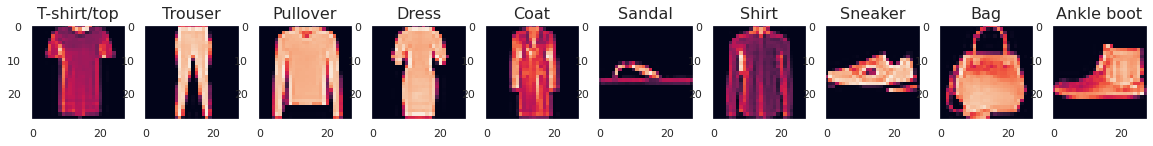

In [ ]:
labels = np.array(['T-shirt/top',	'Trouser', 'Pullover',	'Dress',	'Coat', 'Sandal',	'Shirt',	'Sneaker',	'Bag',	'Ankle boot'])
#rappresentiamo un campione di immagini per ogni categoria
np.random.seed(22)
plt.figure(figsize=(20,20))
for i in range(0,len(np.unique(y_train))):
    rmd = np.random.choice(np.where(y_train==i)[0],1)
    plt.subplot(1,10,i+1)
    img = x_train[rmd]
    plt.imshow(img[0])
    plt.title(labels[i],fontsize=16)
    plt.grid(False)

Per simulare una nuova classe si decide di togliere la classe *'sneaker'* dal training set.

In [ ]:
y_train_no_sneakers = np.delete(y_train,np.where(y_train==7)[0])
x_train_no_sneakers = np.delete(x_train,np.where(y_train==7)[0],axis=0)
print(y_train_no_sneakers.shape)
print(x_train_no_sneakers.shape)
y_train_no_sneakers = np.array(pd.get_dummies(y_train_no_sneakers))
labels_no_sneakers = np.array(['T-shirt/top',	'Trouser', 'Pullover',	'Dress',	'Coat', 'Sandal',	'Shirt', 'Bag',	'Ankle boot'])
print(y_train_no_sneakers.shape)

(54000,)
(54000, 28, 28)
(54000, 9)


Si decide di splittare il dataset di training in train e validation set utilizzando una proporzione 70:30. Arrivati a questo punto si hanno a disposizione 3 dataset:

* Un dataset di training con circa 37'800 osservazioni
* un dataset di validazione con circa 16'200 osservazioni
* un dataset di testing con circa 10'000 osservazioni

ricordando che solo nel dataset di testing vi sono le immagini relative alle *sneakers*.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
x_train, x_val, y_train, y_val = train_test_split(x_train_no_sneakers, y_train_no_sneakers, test_size=0.3, random_state=22)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)
 
x_train = x_train/255.
x_val = x_val/255.
x_test = x_test/255.

(37800, 28, 28)
(37800, 9)
(16200, 28, 28)
(16200, 9)
(10000, 28, 28)
(10000,)


In [ ]:
x_train = np.expand_dims(x_train, -1)
x_val = np.expand_dims(x_val, -1)
x_test = np.expand_dims(x_test, -1)

## Non-Bayesian CNN

In questa sezione si utilizza una CNN con due strati convoluzionali seguiti da due layer di Max Pooling. A seguito dei layer convoluzionali si utilizza un layer Flatten per *'appiattire'* l'informazione proveniente dai layer convoluzionali e aggiungere all'architettura uno strato denso con 100 unità, seguito da un ulteriore strato denso con numero di neuroni pari al numero di classi che si vuole predire.

In [ ]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras import Sequential

model = Sequential([
     Conv2D(64,kernel_size=(3,3), activation = 'relu', input_shape=(28,28,1)),
     MaxPooling2D((2,2)),
     Conv2D(16,kernel_size=(3,3), activation = 'relu'),
     MaxPooling2D((2,2)), 
     Flatten(),
     Dense(100, activation = 'relu'),
     Dropout((0.5)),
     Dense(9, activation = 'softmax')             
])

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 16)        9232      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 400)               0         
                                                                 
 dense_6 (Dense)             (None, 100)              

In [ ]:
batch_size = 64
EPOCHS = 5

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'])
history = model.fit(x_train, y_train, batch_size = batch_size, epochs=EPOCHS, validation_data = (x_val, y_val))

Train on 37800 samples, validate on 16200 samples
Epoch 1/5
37632/37800 [============================>.] - ETA: 0s - loss: 0.7583 - accuracy: 0.7252

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


37800/37800 [==============================] - 6s 171us/sample - loss: 0.7576 - accuracy: 0.7253 - val_loss: 0.4876 - val_accuracy: 0.8212
Epoch 2/5
37800/37800 [==============================] - 6s 160us/sample - loss: 0.5207 - accuracy: 0.8089 - val_loss: 0.4262 - val_accuracy: 0.8331
Epoch 3/5
37800/37800 [==============================] - 6s 160us/sample - loss: 0.4512 - accuracy: 0.8374 - val_loss: 0.3623 - val_accuracy: 0.8636
Epoch 4/5
37800/37800 [==============================] - 6s 160us/sample - loss: 0.4131 - accuracy: 0.8494 - val_loss: 0.3391 - val_accuracy: 0.8722
Epoch 5/5
37800/37800 [==============================] - 6s 161us/sample - loss: 0.3838 - accuracy: 0.8607 - val_loss: 0.3194 - val_accuracy: 0.8830


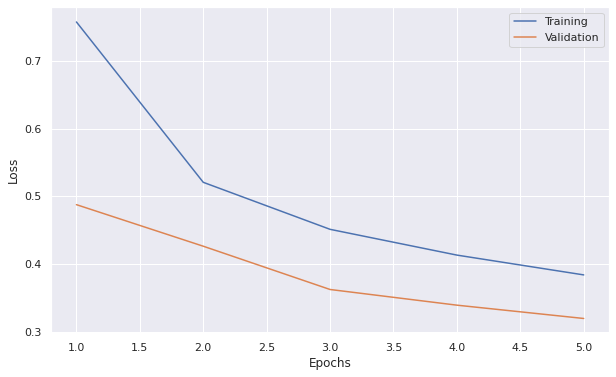

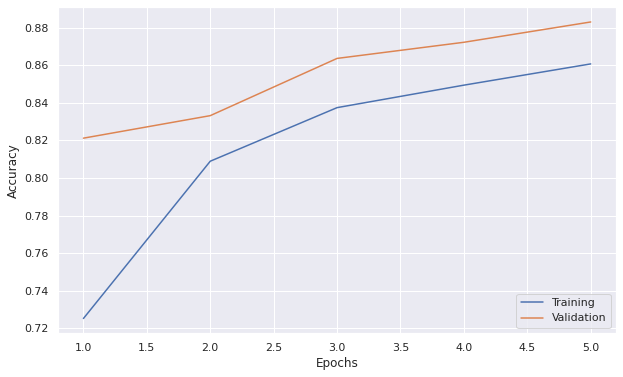

In [ ]:
x_plot = list(range(1,EPOCHS+1))

def plot_history(network_history):
    plt.figure(figsize=(10, 6))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure(figsize=(10, 6))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(history)

## Variational Inference

Si procede con l'implementazione di una *rete neurale bayesiana* tramite ***inferenza variazionale***. L'architettura è la medesima rispetto alla precedente, la differenza sta nel fatto che ora ogni peso all'interno della rete è campionato da una distribuzione normale. Sfruttando la distribuzione normale, tuttavia, ora abbiamo il doppio del numero di parametri da apprendere (media e varianza, senza contare i termini di bias che non vengono modellizzati tramite una distribuzione). 

In [ ]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x_train.shape[0] *1.0)

model_vi = Sequential([
  tfp.layers.Convolution2DFlipout(64,kernel_size=(3,3), activation = 'relu', kernel_divergence_fn=kernel_divergence_fn,input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D((2,2)),
  tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3), activation = 'relu', kernel_divergence_fn=kernel_divergence_fn),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Flatten(),
  tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn),
  tfp.layers.DenseFlipout(9, activation = 'softmax', kernel_divergence_fn=kernel_divergence_fn)
])


model_vi.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_flipout_4 (Conv2DFli  (None, 26, 26, 64)       1216      
 pout)                                                           
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_flipout_5 (Conv2DFli  (None, 11, 11, 16)       18448     
 pout)                                                           
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 5, 5, 16)         0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 400)              

In [ ]:
batch_size = 64
EPOCHS = 8

model_vi.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'])
history = model_vi.fit(x_train, y_train, batch_size = batch_size, epochs=EPOCHS, validation_data = (x_val, y_val))

Train on 37800 samples, validate on 16200 samples
Epoch 1/8
37800/37800 [==============================] - ETA: 0s - loss: 4.0325 - accuracy: 0.7114

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


37800/37800 [==============================] - 15s 386us/sample - loss: 4.0325 - accuracy: 0.7114 - val_loss: 3.6732 - val_accuracy: 0.8021
Epoch 2/8
37800/37800 [==============================] - 10s 272us/sample - loss: 3.4956 - accuracy: 0.8217 - val_loss: 3.3342 - val_accuracy: 0.8391
Epoch 3/8
37800/37800 [==============================] - 10s 267us/sample - loss: 3.1986 - accuracy: 0.8480 - val_loss: 3.0772 - val_accuracy: 0.8540
Epoch 4/8
37800/37800 [==============================] - 10s 268us/sample - loss: 2.9568 - accuracy: 0.8571 - val_loss: 2.8555 - val_accuracy: 0.8598
Epoch 5/8
37800/37800 [==============================] - 10s 266us/sample - loss: 2.7445 - accuracy: 0.8655 - val_loss: 2.6660 - val_accuracy: 0.8629
Epoch 6/8
37800/37800 [==============================] - 10s 271us/sample - loss: 2.5625 - accuracy: 0.8693 - val_loss: 2.4920 - val_accuracy: 0.8680
Epoch 7/8
37800/37800 [==============================] - 13s 351us/sample - loss: 2.3988 - accuracy: 0.8742 - 

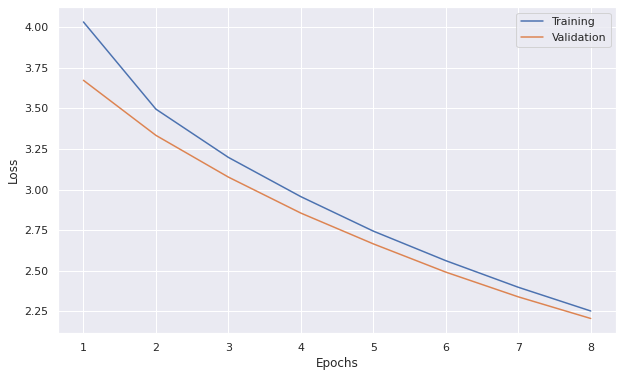

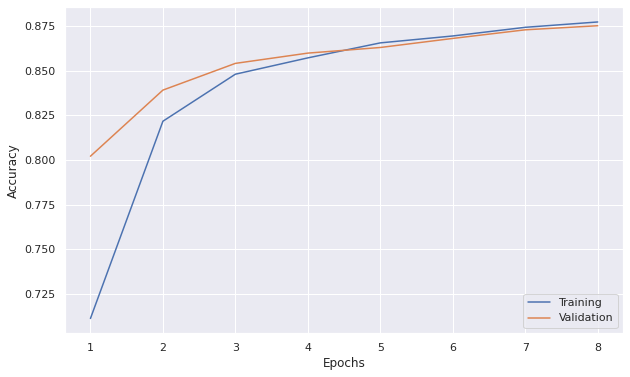

In [ ]:
x_plot = list(range(1,EPOCHS+1))
plot_history(history)

Nel chunk successivo si può osservare come si ottengono previsioni differenti per la stessa immagine, nel momento in cui ripetiamo la medesima previsione 5 volte. Ogni volta che campioniamo un valore diverso di pesi la previsione cambia leggermente.

In [ ]:
for i in range(0,5):
  print(model_vi.predict(x_train[0:1])[0])

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[3.01950513e-05 1.12234495e-07 1.06107723e-06 9.15423399e-08
 9.99897320e-09 9.99718249e-01 2.89522660e-07 1.89616742e-06
 2.48071010e-04]
[3.3409653e-06 2.2164620e-07 1.8895491e-08 6.4912300e-08 3.5892374e-08
 9.9990582e-01 3.3207495e-08 7.2931478e-05 1.7496610e-05]
[5.2308445e-07 3.4323241e-07 4.3267488e-07 3.6492531e-07 1.5130365e-08
 9.9995518e-01 1.5713297e-08 1.2487875e-05 3.0686158e-05]
[1.9221139e-05 4.3927798e-08 4.9511204e-08 3.4099712e-09 1.4760895e-10
 9.9981409e-01 4.9158903e-08 1.6605733e-04 4.2043203e-07]
[1.4347534e-05 5.1539573e-06 1.6421682e-06 4.2652751e-05 2.1669509e-06
 9.9971884e-01 1.1604336e-05 9.8441102e-05 1.0524450e-04]


## MC Dropout

In questa sezione si allena una rete neurale tramite MC Dropout. L'architettura, anche in questo caso, è la medesima rispetto alle due precedenti. Il numero di pesi all'interno della rete è ora uguale a quello presente nella rete neurale non bayesiana.

In [ ]:
model_mc = Sequential([
  Conv2D(64,kernel_size=(3,3),activation = 'relu',input_shape=(28, 28, 1)),
  Dropout((0.3)),
  MaxPooling2D((2,2)),
  Conv2D(32,kernel_size=(3,3), activation = 'relu'),
  Dropout((0.3)),
  MaxPooling2D((2,2)),
  Conv2D(16,kernel_size=(3,3), activation = 'relu'),
  Dropout((0.3)),
  Flatten(),
  Dense(100, activation = 'relu'),
  Dropout((0.3)),
  Dense(9, activation = 'softmax')
])

model_mc.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 dropout_10 (Dropout)        (None, 26, 26, 64)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 11, 11, 32)        18464     
                                                                 
 dropout_11 (Dropout)        (None, 11, 11, 32)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                 

Nei prossimi chunks viene definita una funzione model_mc_pred, che dà la possibilità di utilizzare o bloccare il dropout durante la fase di testing. Se durante la fase di apprendimento viene settato su 0 blocchiamo il dropout durante la fase di previsione (situazione che si verifica durante l'apprendimento di una CNN non probabilistica), mentre se viene settato a 1, attiva il dropout durante la fase di previsione. Quando viene settato su 1, si ottiene una previsione differente per la stessa immagine in ogni run: questo perchè in ogni run nodi diversi vengono eliminati randomicamente. Per utilizzare la rete come se fosse una rete bayesiana, vi è la necessità di attivare il dropout anche durante la fase di previsione.

#### Getting mc dropout predictions

In [ ]:
import tensorflow.keras.backend as K
model_mc_pred = K.function([model_mc.input, K.learning_phase()], [model_mc.output])

In [ ]:
#no dropout at test time
for i in range(0,5):
  print(model_mc_pred([x_train[0:1],0])[0])

[[0.09632179 0.11148387 0.11831427 0.11140901 0.10820265 0.10345163
  0.1179898  0.11183026 0.12099678]]
[[0.09632179 0.11148387 0.11831427 0.11140901 0.10820265 0.10345163
  0.1179898  0.11183026 0.12099678]]
[[0.09632179 0.11148387 0.11831427 0.11140901 0.10820265 0.10345163
  0.1179898  0.11183026 0.12099678]]
[[0.09632179 0.11148387 0.11831427 0.11140901 0.10820265 0.10345163
  0.1179898  0.11183026 0.12099678]]
[[0.09632179 0.11148387 0.11831427 0.11140901 0.10820265 0.10345163
  0.1179898  0.11183026 0.12099678]]


In [ ]:
#dropout at test time
for i in range(0,5):
  print(model_mc_pred([x_train[0:1],1])[0])

[[0.08648393 0.10953309 0.13130488 0.12646444 0.10230281 0.10079263
  0.12157797 0.10438903 0.11715123]]
[[0.062658   0.11261779 0.11605196 0.11718594 0.12009197 0.08121855
  0.13875544 0.11328916 0.1381312 ]]
[[0.0691635  0.08719592 0.13089882 0.12578547 0.1026863  0.09566094
  0.13081066 0.11397855 0.14381984]]
[[0.07923794 0.10953992 0.1446546  0.11637759 0.09876207 0.08211631
  0.1282626  0.11324712 0.1278019 ]]
[[0.07862476 0.1150834  0.1212832  0.10022617 0.12116335 0.09268477
  0.11986718 0.10060336 0.15046377]]


In [ ]:
batch_size = 64
EPOCHS = 5

model_mc.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.01), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'])
history = model_mc.fit(x_train, y_train, batch_size = batch_size, epochs=EPOCHS, validation_data = (x_val, y_val))

Train on 37800 samples, validate on 16200 samples
Epoch 1/5
37760/37800 [============================>.] - ETA: 0s - loss: 0.7176 - accuracy: 0.7277

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


37800/37800 [==============================] - 12s 313us/sample - loss: 0.7176 - accuracy: 0.7278 - val_loss: 0.5508 - val_accuracy: 0.8056
Epoch 2/5
37800/37800 [==============================] - 11s 302us/sample - loss: 0.5788 - accuracy: 0.7842 - val_loss: 0.5067 - val_accuracy: 0.8158
Epoch 3/5
37800/37800 [==============================] - 11s 302us/sample - loss: 0.5489 - accuracy: 0.7953 - val_loss: 0.4615 - val_accuracy: 0.8304
Epoch 4/5
37800/37800 [==============================] - 11s 296us/sample - loss: 0.5485 - accuracy: 0.7962 - val_loss: 0.4617 - val_accuracy: 0.8330
Epoch 5/5
37800/37800 [==============================] - 11s 297us/sample - loss: 0.5415 - accuracy: 0.7996 - val_loss: 0.4616 - val_accuracy: 0.8283


In [ ]:
model_mc.save('model_mc')

INFO:tensorflow:Assets written to: model_mc/assets


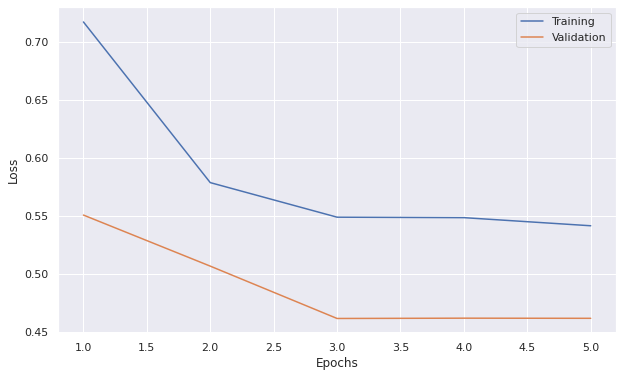

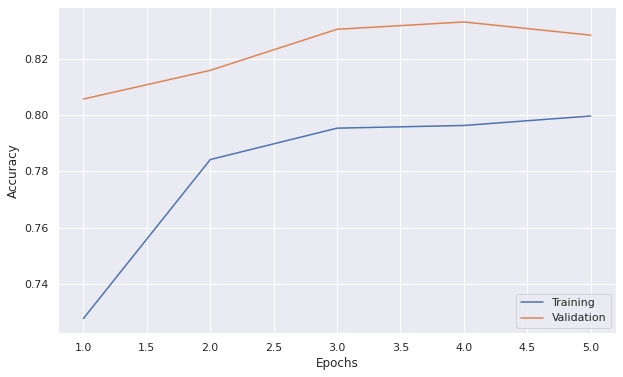

In [ ]:
x_plot = list(range(1,EPOCHS+1))
plot_history(history)

## Accuracy on the the known lables in the train set for all three models 

Nella seguente sezione viene calcolata l'accuratezza dei tre modelli stimati. 
* Per il primo modello implementato, quello non bayesiano, si procede alle previsione dei dati di test una sola volta
* Per i due modelli bayesiani si itera la procedura di previsione 50 volte e si prende una media di questa.






In [ ]:
known_idx=np.where(y_test!=7)[0]
unknown_idx=np.where(y_test==7)[0]

print(len(known_idx))
print(len(unknown_idx))

9000
1000


#### Non-Bayesian prediction

In questo caso si andranno a predire le labels del test set tramite la CNN non bayesiana e si calcolano le misure di incertezza. Viene calcolata la **Negative log-likelihood** e l'**entropia**.

In [ ]:
pred = model.predict(x_test)
pred_max_p = np.max(pred,axis=1)
entropy = np.array([-np.sum( pred[i] * np.log2(pred[i] + 1E-14)) for i in range(0,len(pred))])
nll_ = -np.log(pred_max_p)
pred_labels = np.array([labels_no_sneakers[np.argmax(pred[i])] for i in range(0,len(pred))])
true_labels = np.array([labels[y_test[i]] for i in range(0,len(y_test))])

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
test_acc_all = np.average(true_labels==pred_labels) #accuratezza verso le immagini del test set (compreso le immagini che ritraggono sneakers)
test_acc_known = np.average(true_labels[known_idx]==pred_labels[known_idx]) #accuratezza verso le immagini note
test_acc_all, test_acc_known

(0.7896, 0.8773333333333333)

#### Bayesian VI prediction

In questo caso prevediamo le etichette del test set tramite la CNN bayesiana in cui si è utilizzata l'inferenza variazionale e si calcolano opportune metriche per valutare il grado di incertezza. Per ciascuna immagine del test set iteriamo la procedura previsiva 50 volte e si calcola la **media delle probabilità predette**, la **nll**, l'**entropia** e la **deviazione standard totale**.

In [ ]:
pred_vi=np.zeros((len(x_test),9))
pred_max_p_vi=np.zeros((len(x_test)))
pred_std_vi=np.zeros((len(x_test)))
entropy_vi = np.zeros((len(x_test)))

for i in tqdm(range(0,len(x_test))):
  multi_img=np.tile(x_test[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_vi[i]=np.mean(preds,axis=0)#mean over n runs of every proba class
  pred_max_p_vi[i]=np.argmax(np.mean(preds,axis=0))#mean over n runs of every proba class
  pred_std_vi[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
  entropy_vi[i] = -np.sum( pred_vi[i] * np.log2(pred_vi[i] + 1E-14)) #Numerical Stability
pred_labels_vi=np.array([labels_no_sneakers[np.argmax(pred_vi[i])] for i in range(0,len(pred_vi))])
pred_vi_mean_max_p=np.array([pred_vi[i][np.argmax(pred_vi[i])] for i in range(0,len(pred_vi))])
nll_vi=-np.log(pred_vi_mean_max_p)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
test_acc_all_vi=np.average(true_labels==pred_labels_vi)
test_acc_known_vi=np.average(true_labels[known_idx]==pred_labels_vi[known_idx])
test_acc_all_vi, test_acc_known_vi

(0.7951, 0.8834444444444445)

#### Bayesian MC prediction

Iteriamo la procedura dello step precedente

In [ ]:
pred_mc=np.zeros((len(x_test),9))
pred_max_p_mc=np.zeros((len(x_test)))
pred_std_mc=np.zeros((len(x_test)))
entropy_mc = np.zeros((len(x_test)))

for i in tqdm(range(0,len(x_test))):
  multi_img=np.tile(x_test[i],(50,1,1,1))
  preds=model_mc_pred([multi_img,1])
  pred_mc[i]= np.mean(preds,axis=1)
  pred_max_p_mc[i]=np.argmax(np.mean(preds,axis=1))#mean over n runs of every proba class
  pred_std_mc[i]= np.sqrt(np.sum(np.var(preds, axis=1)))
  entropy_mc[i] = -np.sum( pred_mc[i] * np.log2(pred_mc[i] + 1E-14)) #Numerical Stability
pred_labels_mc=np.array([labels_no_sneakers[np.argmax(pred_mc[i])] for i in range(0,len(pred_mc))])
pred_mc_mean_max_p=np.array([pred_mc[i][np.argmax(pred_mc[i])] for i in range(0,len(pred_mc))])
nll_mc=-np.log(pred_mc_mean_max_p)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
test_acc_all_mc=np.average(true_labels==pred_labels_mc)
test_acc_known_mc=np.average(true_labels[known_idx]==pred_labels_mc[known_idx])
test_acc_all_mc, test_acc_known_mc

(0.7438, 0.8264444444444444)

Osservando l'accuratezza nel prevedere correttamente le labels del test set si osserva che il secondo modello, basato sulla tecnica dell'inferenza variazionale, è il modello che performa meglio. Viceversa, il modello bayesiano basato su MC Dropout è quello che performa peggio (il che è, tuttavia, comprensibile, dato che ad un numero di dropout maggiore non si è modificata l'architettura in modo da renderla più profonda).

In [ ]:
import pandas as pd
pd.DataFrame(np.array([[test_acc_known,test_acc_known_vi,test_acc_known_mc],[test_acc_all,test_acc_all_vi,test_acc_all_mc]]), index=['test acc on known labels','test acc on all labels'],columns=['Non-Bayesian','VI','MC'])

,Non-Bayesian,VI,MC
test acc on known labels,0.877333,0.884333,0.826444
test acc on all labels,0.789600,0.795900,0.743800


#### Predicted classes for the unknown class
Ora l'idea è quella di osservare come i modelli hanno classificato le osservazioni provenienti dalla *'nuova'* classe, quella non nota (sneakers). 

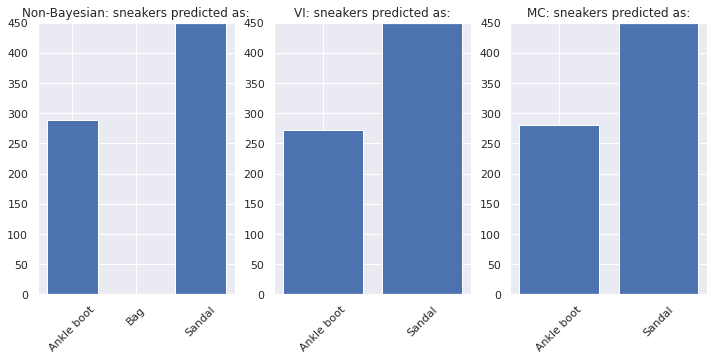

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.bar(np.unique(pred_labels[unknown_idx],return_counts=True)[0],np.unique(pred_labels[unknown_idx],return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("Non-Bayesian: sneakers predicted as:")
plt.ylim([0,450])

plt.subplot(1,3,2)
plt.bar(np.unique(pred_labels_vi[unknown_idx],return_counts=True)[0],np.unique(pred_labels_vi[unknown_idx],return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("VI: sneakers predicted as:")
plt.ylim([0,450])

plt.subplot(1,3,3)
plt.bar(np.unique(pred_labels_mc[unknown_idx],return_counts=True)[0],np.unique(pred_labels_mc[unknown_idx],return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("MC: sneakers predicted as:")
plt.ylim([0,450])

plt.show()

Come lecito aspettarsi, la maggior parte delle sneakers sono state classificate come sandali, nella maggioranza dei casi, o tramite stivali. Queste due categorie sono, effettivamente, quelle più simili alla categoria non nota ai classificatori.

#### Compare the predictions for a known and unknown image

Si confrantano i risultati dei tre modelli utilizzando un'immagine nota e una non nota. Le reti bayesiane prevederanno la stessa immagine 50 volte.

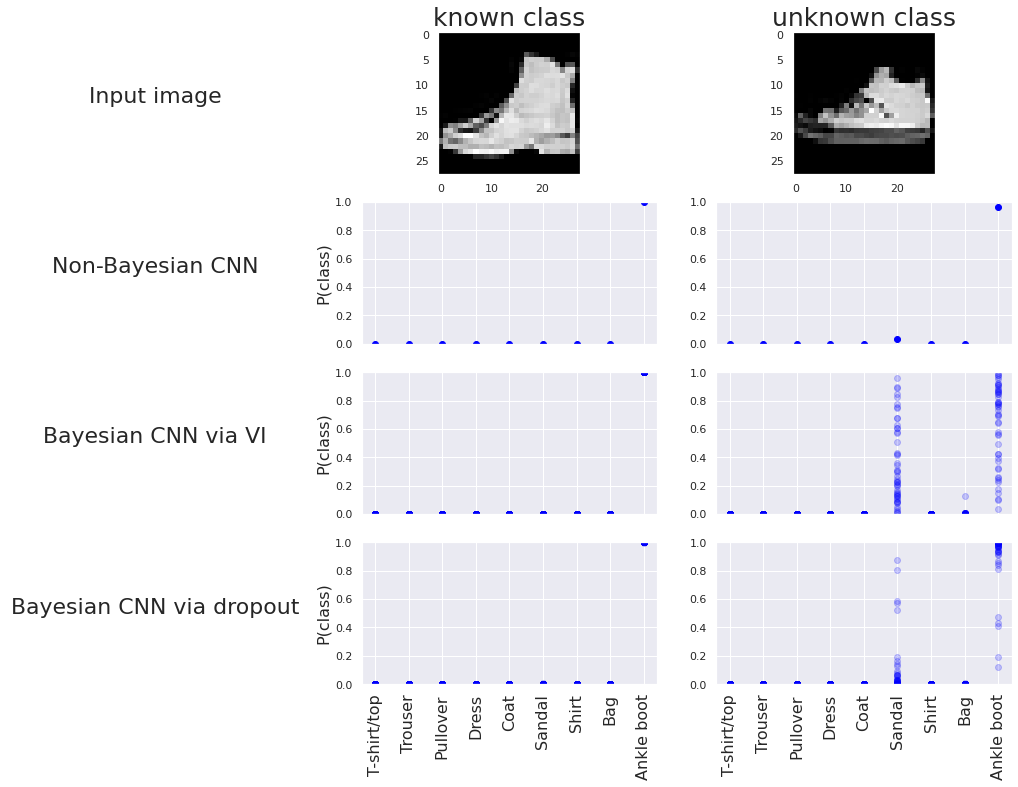

In [ ]:
x_test_known = x_test[known_idx]
y_test_known = y_test[known_idx]

x_test_unknown = x_test[unknown_idx]
y_test_unknown = y_test[unknown_idx]

np.random.seed(7681)
random_sample_known=np.random.choice(range(0,len(x_test_known)),1)
np.random.seed(4)
random_sample_unknown=np.random.choice(range(0,len(x_test_unknown)),1)

plt.figure(figsize=(18,12))
plt.subplot(4,3,1)
plt.axis('off')
plt.text(0.5,0.5, "Input image",fontsize=22,horizontalalignment='center')
plt.subplot(4,3,2)
plt.imshow(np.squeeze(np.array(((((x_test_known[random_sample_known])))*255),dtype="uint8")), cmap = 'gray')
plt.grid(False)
plt.title("known class",fontsize=25)
plt.subplot(4,3,3)
plt.imshow(np.squeeze(np.array(((((x_test_unknown[random_sample_unknown])))*255),dtype="uint8")), cmap = 'gray')
plt.grid(False)
plt.title("unknown class",fontsize=25)

plt.subplot(4,3,4)
plt.axis('off')
plt.text(0.5,0.5, "Non-Bayesian CNN",fontsize=22,horizontalalignment='center')
plt.subplot(4,3,5)
plt.scatter(range(0,9),model.predict(x_test_known[random_sample_known]),c="blue")
plt.ylabel("P(class)",fontsize=16)
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])
plt.subplot(4,3,6)
plt.scatter(range(0,9),model.predict(x_test_unknown[random_sample_unknown]),c="blue")
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])

plt.subplot(4,3,7)
plt.axis('off')
plt.text(0.5,0.5, "Bayesian CNN via VI",fontsize=22,horizontalalignment='center')
plt.subplot(4,3,8)
for i in range(0,50):
  plt.scatter(range(0,9),model_vi.predict(x_test_known[random_sample_known]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])
plt.ylabel("P(class)",fontsize=16)
plt.subplot(4,3,9)
for i in range(0,50):
  plt.scatter(range(0,9),model_vi.predict(x_test_unknown[random_sample_unknown]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])

plt.subplot(4,3,10)
plt.axis('off')
plt.text(0.5,0.5, "Bayesian CNN via dropout",fontsize=22,horizontalalignment='center')
plt.subplot(4,3,11)
for i in range(0,50):
  plt.scatter(range(0,9),model_mc_pred([x_test_known[random_sample_known],1]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=labels_no_sneakers,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.ylabel("P(class)",fontsize=16)
plt.subplot(4,3,12)
for i in range(0,50):
  plt.scatter(range(0,9),model_mc_pred([x_test_unknown[random_sample_unknown],1]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=labels_no_sneakers,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.savefig("8.good2.pdf")
plt.show()
#from google.colab import files
#files.download('8.good2.pdf') 

Guardando le previsioni quello di cui ci si accorge è che le reti bayesiane sono in grado di esprimere incertezza in modo migliore rispetto alle reti tradizionali. Tutte e 3 le reti, invece, sembrano concordare su quella che è la classe dell'immagine nota
